# 08. Third Attempt with Learning from Wrong Answers

## 실패는 '더 현명하게' 다시 시작할 기회를 제공한다.

지금까지는 비교적 잘 작성된 agent끼리 둔 기보,
즉 일종의 모법답안을 바탕으로
신경망을 학습을 시켰습니다.
그리고 이 방식으로 학습을 하였을 때는
흔히 자신이 잘못 두는 경우를 제대로 학습하지
못한다는 것을 알게 되었습니다.

이를 해결하기 위해서 여기서부터는
모법답안을 학습하는 중간에 직접 게임을 플레이해보고
그렇게 얻은 오답노트를 학습하는 과정을 추가합니다.

### 오답노트

사실 MCTS 자체는 오답노트를 중심으로 학습을
합니다.
처음에는 트리를 따라서 적절히 승률이 높은 방향으로
탐색을 하며 내려간 뒤에, 최종 결과에 따라
결과가 긍정적이냐 부정적이냐에 따라 각 노드에
결과를 누적하게 됩니다.
이 누적하는 과정 자체가 오답노트를 이용해
긍정적인 방향의 행동을 하도록 학습하는
과정이 됩니다.

여기서도 마찬가지의 방식을 적용할 것입니다.
다만 게임을 누구와 진행하느냐가 문제가 될 수
있는데, 우선은 `agent_analysis_based`
를 이기는 것으로 목표로 하기 때문에,
이 agent와 싸워서 얻은 기보를 바탕으로 복기를
합니다.

다만, 무작정 오답노트를 적용하기에는
몇가지 문제가 있습니다.

- 신경망은 pure function이기 때문에 같은 입력에
대해서 같은 결과를 내놓습니다.
`agent_analysis_based`는 내부적으로 각 
위치별로 노이즈를 섞어서 비교하기 때문에 가치가
동일한 수들에 대해서는 랜덤하게 선택하지만,
각 수의 가치가 모두 다른 경우에는
사실상 pure function처럼 동작합니다.
이 때문에 순수한 `agent_analysis_based`끼리만
대결을 할 경우에는 처음 몇 수를 제외하고는
일정한 기보만 나오게 되며,
신경망과 대결을 하는 경우에도 비슷할 것이라고
볼 수 있습니다.
즉, 신경망이 일정한 상황에서 `agent_analysis_based`와 대결하여서
얻을 수 있는 유의미하게 다른 기보는 몇개 없습니다.
이 때문에 한번에 대량의 오답노트 batch를 얻는
것에는 무리가 있으며, random이나
training을 통해 신경망의 수를 흐뜨려놓는
과정이 중간중간에 필요할 수 있습니다.
- 기본적인 initialization에서는 생각보다
학습이 빠르게 이루어지지 않습니다.
이 때문에 처음에는 약간 시간을 들이더라도
다른 agent의 플레이인 모범답안을 바탕으로
어느 정도 초기화를 시킨 뒤 강화학습을 할
필요가 있습니다.

따라서 아래와 같은 방식으로 학습을 진행합니다.

1. 신경망을 생성한 뒤 기존의 기보 생성기로 만든
기보로 학습하며 초기화를 해줍니다.
2. 기보 생성기로 소량의 기보를 만든 뒤
짧은 epoch로 여러번 끊어서 학습을 시킵니다.
3. 2의 학습을 진행하는 중간중간에 
신경망-신경망, 신경망-`agent_analysis_based`
와 같이 대전상대를 바꿔서 기보를 생성합니다.
이 때 신경망-신경망은 사실상 대칭이므로 1개의
기보가 만들어지며, 신경망-`agent_analysis_based`
는 선후공 교대에 따라 최소 2개의 기보가 만들어집니다.
이 기보가 '오답노트'로써 누적이 됩니다.
4. 생성된 기보를 이용한 학습이 끝났다면
'오답노트'를 이용하여 비교적 긴 epoch동안
학습을 시킵니다.

여기서 2-3처럼 모범답안 학습과 대결을
섞는 것은 신경망을 흐뜨려서 조금 다른 기보를
더 생성하기 위함입니다.

기존에는 대략 5k-50k개 정도의 오목판을
batch로 하여 학습을 시켰습니다.
그런데 오답노트를 만들 때 한번에 3개의 기보가
나오게 되며, 각 기보에는 최소 9개의
오목판 상태가 존재하므로, 오답노트 하나에는
최소 27개의 오목판이 생겨나며,
대칭으로 변환을 하면
$27 \times 16 = 432$개의 오목판 상태가
생겨납니다.
만약 기존의 batch size에 근접시키고 싶다면
못해도 10번의 실전을 시행해야 하는 양입니다.

## 환경설정

오목 학습에 필요한 모듈들을 모두 불러옵니다.

In [1]:
!rm -rf *
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 117 (delta 52), reused 106 (delta 41), pack-reused 0
Receiving objects: 100% (117/117), 34.72 KiB | 11.57 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
from mock5.agent_random import agent as m5agent_random
from mock5.agent_analysis_based import agent as m5agent_a

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

Device: cuda


## 크기 설정

In [3]:
# Board Size
W = 11
H = W

## 신경망

In [4]:
class Flatten(torch.nn.Module):
  def forward(self, x):
    return x.flatten(1, -1)

class FlatSum(torch.nn.Module):
  def forward(self, x):
    while len(x.shape) > 2:
      x = x.sum(dim=-1)
    return x.sum(dim=-1, keepdim=True)

In [135]:
LW = W // 2
model = nn.Sequential(
    nn.Conv2d(3, 128, 5, padding='same'),
    nn.LeakyReLU(1e-1),
    nn.Conv2d(128, 128, 5, padding='same'),
    nn.LeakyReLU(1e-1),
    nn.Conv2d(128, 16, 3, padding='same'),
    nn.AvgPool2d(W),
    Flatten(),
    nn.Linear(16, 1),
    nn.Tanh(),
).to(device)

loss_fn = nn.MSELoss()

In [6]:
def agent_model(game):
  idxs, Xs = game.tensors_with_a_stone()
  X = Xs.to(device)
  with torch.no_grad():
    y = model(X)
  j = torch.argmax(y)
  k = idxs[j]
  return (k // W), (k % W)

In [112]:
def agent_model_exp(game):
  idxs, Xs = game.tensors_with_a_stone()
  X = Xs.to(device)
  with torch.no_grad():
    y = model(X)
  j = torch.argmax(y)
  p = len(idxs)
  while p > 2 and np.random.random() < 0.3:
    p -= 1
    y[j] = -100
    j = torch.argmax(y)
  k = idxs[j]
  return (k // W), (k % W)

In [122]:
def agent_mixed(game):
  import random
  if random.random() < 0.6: return agent_model_exp(game)
  else: return m5agent_a(game)

## 데이터 생성

In [7]:
from read_record import conv_records_from_array
from read_record import conv_records_from_file

In [8]:
import os
def gen_data(size, rnd):
  filename = "temp.data"
  os.system("./gen {} {} {} {} {}".format(filename, size, H, W, rnd))
  return conv_records_from_file(W, filename)

## 실전을 시행하는 함수

In [9]:
def run_game(agent1, agent2, random_first=True):
  game = Mock5(H, W)
  result = game.play(
      agent1, agent2,
      random_first=random_first,
      print_intermediate_state=False,
      print_messages=False)
  print(game)
  return game, result

In [10]:
def make_data_from_game_between(agent1, agent2):
  g, r = run_game(agent1, agent2, random_first=False)
  i2arr = g.make_history_int_pair_array(r)
  return conv_records_from_array(W, i2arr)

In [131]:
def make_data_from_game(n_vs_model=1, n_vs_agent=2):
  Xs = []
  Ys = []
  for i in range(n_vs_model):
    X, Y = make_data_from_game_between(agent_mixed, agent_mixed)
    Xs.append(X)
    Ys.append(Y)
  for i in range(n_vs_agent):
    X, Y = make_data_from_game_between(agent_model, m5agent_a)
    Xs.append(X)
    Ys.append(Y)
    X, Y = make_data_from_game_between(m5agent_a, agent_model)
    Xs.append(X)
    Ys.append(Y)
  X = torch.cat(Xs, dim=0)
  Y = torch.cat(Ys, dim=0)
  return X, Y

## 학습

In [12]:
def learn_batch(opt, n_epoch, X, Y):
  log_int = max(100, int(n_epoch / 5))
  acc_n, acc_loss = 0, 0
  acc_loss = 0

  print("-- Learn Batch --")
  torch.cuda.empty_cache()
  X = X.to(device)
  Y = Y.to(device)
  ys = torch.abs(Y).mean()

  for epoch in range(n_epoch):
    opt.zero_grad()
    Y_ = model(X)
    loss = loss_fn(Y_, Y)
    loss.backward()
    opt.step()

    acc_loss += loss.item() / ys.item()
    acc_n += 1

    if epoch % log_int == log_int - 1 or epoch == n_epoch - 1:
      print("E {:.3f}: Loss = {:.6f}".format(
          (epoch + 1) / n_epoch, acc_loss / acc_n))
      acc_loss, acc_n = 0, 0

In [13]:
def learn_with_generated(opt, n_epoch, batch_size, epsilon):
  X, Y = gen_data(batch_size, epsilon)
  print("Batch Size: {} (generated)".format(Y.shape[0]))
  return learn_batch(opt, n_epoch, X, Y)

In [70]:
def learn_from_game(opt, ratio_epoch, n_vs_model=1, n_vs_agent=3):
  X, Y = make_data_from_game(n_vs_model=n_vs_model, n_vs_agent=n_vs_agent)
  print("Batch Size: {} (from game)".format(Y.shape[0]))
  return learn_batch(opt, max(1, int(ratio_epoch * Y.shape[0])), X, Y)

In [136]:
print("===== Initialization =====")
opt = optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.8,
    weight_decay=1e-2,
    nesterov=True)
for i in range(5):
  print("=== {}-th init ===".format(i + 1))
  learn_with_generated(opt, 100, 10, 0.01)

===== Initialization =====
=== 1-th init ===
Batch Size: 4512 (generated)
-- Learn Batch --
E 1.000: Loss = 0.999022
=== 2-th init ===
Batch Size: 7120 (generated)
-- Learn Batch --
E 1.000: Loss = 0.996882
=== 3-th init ===
Batch Size: 7536 (generated)
-- Learn Batch --


KeyboardInterrupt: ignored

In [140]:
print("===== Main Learning =====")
opt = optim.SGD(
    model.parameters(),
    lr=1e-3,
    momentum=0.5,
    weight_decay=1e-4,
    nesterov=True)
for i in range(100):
  print("=== {}-th leran ===".format(i + 1))
  learn_with_generated(opt, 50, 10, 0.05)
  for j in range(20):
    print("--- {}-{}-th game ---".format(i + 1, j + 1))
    learn_from_game(opt, 1, n_vs_model=1, n_vs_agent=1)

===== Main Learning =====
=== 1-th leran ===
Batch Size: 6992 (generated)
-- Learn Batch --
E 1.000: Loss = 0.997252
--- 1-1-th game ---
 [ Turn  22 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . . . . X . .
2 | . . . . O O O X . . .
3 | . . . . O X X X . . .
4 | . . . . O X O . . . .
5 | . . . . X X X . . . .
6 | . . . O O O X O . . .
7 | . . . . . O X . . . .
8 | . . . . . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
 [ Turn  10 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . . . . . . .
2 | . . . . . . . . . . .
3 | . . . X O . . . . . .
4 | . . . . X O O . . . .
5 | . . . . . X . . . . .
6 | . . . . O O X . . . .
7 | . . . . . . . X . . .
8 | . . . . . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
 [ Turn   9 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . 

KeyboardInterrupt: ignored

## 평가

In [141]:
def test_agents(num_game, agent1, agent2):
  w1, w2 = 0, 0
  for i in range(num_game):
    g, result = run_game(agent1, agent2)
    if result == 1: w1 += 1
    elif result == 2: w2 += 1
  print("-- Test Result --")
  print("Agent1 = {} / Agent2 = {}".format(agent1, agent2))
  print("Total: {}".format(num_game))
  print("A1 Win: {} ({:.3f})".format(w1, w1 / num_game))
  print("A2 Win: {} ({:.3f})".format(w2, w2 / num_game))

In [142]:
test_agents(20, m5agent_random, agent_model)

 [ Turn  10 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . O . . . . . . . . .
1 | O . . . . . . . . . .
2 | . . . . . . . . . . .
3 | . . . X . . . . O . .
4 | . . . . X . . . . . .
5 | . . . . . X . . . . .
6 | . O . . . . X . . . .
7 | . . . . . . . X . . .
8 | . . . . . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . O . . .
 [ Turn  16 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . O . O .
1 | O . O . . . . . . . .
2 | O . . . . . . . . . .
3 | . . . X . X . . . . .
4 | . . . . X . X . . . .
5 | . . . . . X . X . . .
6 | . . . . . . X . . . .
7 | . . . . . . . X . . .
8 | . . . . . . . . . . .
9 | . . . O . . . . . . .
A | . O . . . . . O . . .
 [ Turn  28 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | O . . . . . . . . . .
1 | . . . . . . . . . . .
2 | . . . . . O . . O . .
3 | . . . . X X X X . . .
4 | . . O . X X O . . . .
5 | . . . . X X X O . O O
6 | .

 [ Turn  29 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | X . . . X . . . . . .
1 | . . . . . . . . . . .
2 | . . . . . X . . . . .
3 | . . . . O O X X . . .
4 | . . . O O X O . . X .
5 | . . . O O O O . . . .
6 | . X . . O O O . . . .
7 | X . . X . O O . . . .
8 | X . . . . . O . . . .
9 | X . . X X . . . . . .
A | . . . . . . . . . . .
1p (<function agent_model at 0x7f1ae21007a0>) win!


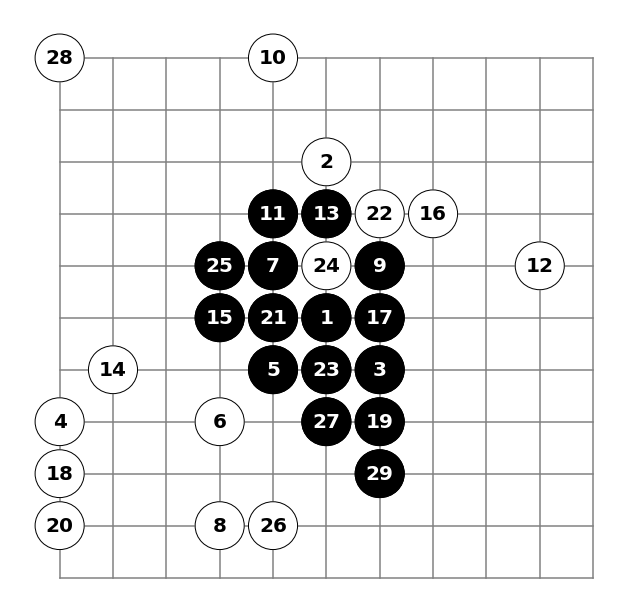

In [143]:
g = Mock5(H, W)
g.play(m5agent_random, agent_model,
       print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

 [ Turn   9 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . . . . . . .
2 | . . . . . . . . . . .
3 | . . . O X . X . . . .
4 | . . . . O X . . . . .
5 | . . . . . O X . . . .
6 | . . . . . . O . . . .
7 | . . . . . . . O . . .
8 | . . . . . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
1p (agent-analysis-based) win!


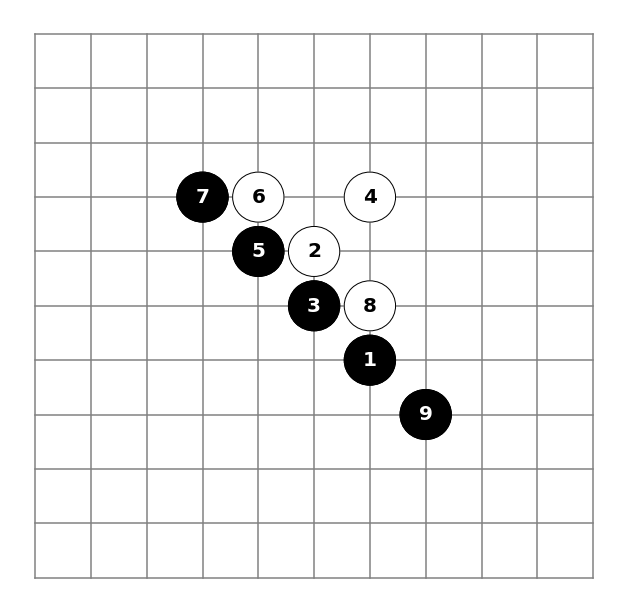

In [144]:
g = Mock5(H, W)
g.play(m5agent_a, agent_model,
       print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

## 생각해볼 점

실제로 학습 시 이전보다 더 나아지지 않았다.

신경망이나 학습하는 순서 등을 조절하다보면
기존처럼 9수만에 지는 대신에 조금 더 버틸 수는
있지만, 사실상 재현이 힘듭니다.
지금 신경망으로도 공방이 가능할 수 있다는 것을
보여주지만, 그 정도에 불과합니다.

학습할 model과 `agent_anlysis_based`를
직접 맞붙이게 되면,
두면 안 되는 지점에 대해 결과가 누적이
되지만, 
반대로 그 상황에 대해 두어야 할 지점에
대해 누적되는 결과가 없습니다.
때문에 '이렇게 두면 안 된다'라는 것은
누적이 되어도 '이렇게 둬야 한다'라는
정보가 없다보니, 몇몇 한정된 수를 반복적으로 두게
됩니다.

다음에는 `agent_analysis_based`를
바탕으로 모범적인 수와, 좋지 않은 수를
같이 학습하도록 할 것입니다.